# Prediction of eventual sepsis onset
LSTM model with simple imputation

## Data prep

In [0]:
import numpy as np
import pandas as pd
import os
import random
import pickle
import math
import missingno as msno
from multiprocessing.dummy import Pool as ThreadPool
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# download data
import os
import urllib.request
urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip','training_setA.zip')
urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setB.zip','training_setB.zip')
# unzip
!unzip -q training_setA.zip
!unzip -q training_setB.zip
# delete zip file
!rm training_setA.zip
!rm training_setB.zip
!mv training training_setA

In [0]:
def impute_missing_vals(df):

    """
    function that imputes missing values.
    
    @param df: dataframe that has missing values to be
               imputed
    @return df_clean: dataframe without missing values and indicators for missigness

    """
    
    """
    fill missing values by the closest values first
    ffill to fill missing values in the tail
    bfill to fill missing values in the head
    """
    df_clean = df.copy()
    lab_attributes = df_clean.columns[7:33]
    all_attributes = df_clean.columns

    for att in lab_attributes: 
        df_clean['missing_'+att]=1*np.array(df_clean[att].isnull())
        
    for att in all_attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0)
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill()
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both') 
            df_clean[att] = df_clean[att].ffill().bfill()

    return df_clean


In [0]:
data_path = ["training_setA","training_setB" ]
patient_id = [sorted(os.listdir(data_path[0])), sorted(os.listdir(data_path[1]))]
data = [] # list of df for each patient, not imputed

for hosp in range(2):
    for p in patient_id[hosp]:
        # read in patient data
        df = pd.read_csv(data_path[hosp] + '/' + p, sep = "|")
        attributes = df.columns[:-1]
        # drop unit1 and unit2 with half missing values
        # because these two features have few information
        # drop EtCO2 with all missing values
        df = df.drop(['Unit1', 'Unit2', 'EtCO2'], axis=1)
        data.append(df)

In [0]:
np.random.seed(66) # for consistency of shuffle

def prep_data_detection_parallel(test_offset = -3, train_offset = 6, max_hour = 96, test_prop = 0.2, val_prop = 0.1):
    # helper for frame 
    def prep_frame_detection(patient):
    # get time-to-sepsis label for every hour of patient
        eventual_sepsis = 0
        time_of_sepsis = max_hour
        for index, row in patient.iterrows():
            if int(row['SepsisLabel'])>0 and index <= max_hour:
                time_of_sepsis = index + 6
                eventual_sepsis = 1
                break
        
        times_of_sepsis = []
        for index, row in patient.iterrows():
            if eventual_sepsis == 1:
                times_of_sepsis.append(max(time_of_sepsis-index,0)) # time_to_sepsis is >=0 
            else:
                times_of_sepsis.append(max_hour) # if sepsis doesnt occur, then time_of_sepsis same as censoring
                
        patient_df = patient.copy()
        patient_df['TimeToSepsis'] = times_of_sepsis
        patient_df['EventualSepsis'] = len(patient_df)*[eventual_sepsis]
        patient_df = patient_df[:max_hour] # get rid of data that exceeds the first max_hour hours
        return patient_df

    # 1) get information time_of_sepsis and eventual_sepsis and split into train_val_test
    # max_hour is  number of hours to keep track of, if sepsis develops after max_hour of stay or never
    np.random.shuffle(data) # shuffle the order
    #Create time-to-sepsis column
    times = [] # keep track of all time-to-sepsis for analysis 
    lenghts = [] # lenght of patient stays
    data_df = [] # holds new data
    pool = ThreadPool(100)
    data_df = pool.map(prep_frame_detection, data)

    data_train_raw = data_df[:math.ceil(len(data_df)*(1-test_prop - val_prop))]
    data_val_raw = data_df[math.ceil(len(data_df)*(1-test_prop - val_prop)):math.ceil(len(data_df)*(1-test_prop - val_prop)) +  math.ceil(len(data_df)*(val_prop))]
    data_test_raw = data_df[math.ceil(len(data_df)*(1-test_prop - val_prop)) +  math.ceil(len(data_df)*(val_prop)):]
    return data_train_raw, data_val_raw, data_test_raw

def impute_data_detection(data_train_raw, data_val_raw, data_test_raw, test_offset = -3, train_offset = 6, max_hour = 72 ):
    # 2) truncate train to some constant offset, truncate test and val depending on the val, and then impute
    def impute_training(patient):
        patient_df = None
        if patient.EventualSepsis[0] == 1:
            time_of_sepsis = patient.TimeToSepsis[0]
            patient_df = patient.copy()[:max(time_of_sepsis + train_offset ,1)] # for sepsis in training set, keep 6 hours after onset, this is a hyperparameter 
        else:
            patient_df = patient.copy() 
        return impute_missing_vals(patient_df)

    def impute_testing(patient):
        patient_df = None
        if patient.EventualSepsis[0] == 1:
            time_of_sepsis = patient.TimeToSepsis[0]
            patient_df = patient.copy()[:max(time_of_sepsis + test_offset ,1)] # for sepsis in test/val set, keep test_offset hours before onset
        else:
            patient_df = patient.copy()
        return impute_missing_vals(patient_df)

    pool = ThreadPool(100)
    print("Imputing training data...")
    data_train = pool.map(impute_training, data_train_raw)
    print("Imputing validation data...")
    data_val = pool.map(impute_testing, data_val_raw)
    print("Imputing testing data...")
    data_test = pool.map(impute_testing, data_test_raw)
    return data_train, data_val, data_test


In [0]:
max_hour = 96
data_train_raw, data_val_raw, data_test_raw = prep_data_detection_parallel(test_offset = 1, train_offset = 1, max_hour = 96, test_prop = 0.20, val_prop = 0.05)

In [0]:
data_train, data_val, data_test = impute_data_detection(data_train_raw, data_val_raw, data_test_raw, test_offset = 0 , train_offset = 0, max_hour = 72 )

Imputing training data...
Imputing validation data...
Imputing testing data...


In [0]:
print(len(data_train))
print(len(data_val))
print(len(data_test))

30252
2017
8067


 Pytorch dataset class, features:

 - sorts data by lenght, then collate pads only within batches to minimize padding

In [0]:
input_dim = 63 # known

In [0]:

class SepsisDataset(Dataset):
    def __init__(self, data_df, seq_lenght):
        """
        data_df: what is obtained from the above
        """
        data_x = []
        data_y = []
        for i in range(len(data_df)):
            x = data_df[i][:seq_lenght] # keep only first seq_lenght hours
            y = torch.from_numpy(x.EventualSepsis.to_numpy()).long()[0] # for CE
            x = x.drop(columns=["TimeToSepsis", "SepsisLabel","EventualSepsis"])
            x = torch.from_numpy(x.to_numpy()).float() # for LSTM compatibility
            data_x.append(x)
            data_y.append(y)
        # sort by sequence lenght
        data_x_sorted, data_y_sorted = (list(t) for t in zip(*sorted(zip(data_x, data_y),key=self.key_tensor)))

        self.data_x = data_x_sorted
        self.data_y = data_y_sorted
    
    def key_tensor(self, elem):
        return elem[0].size()[0] # get sequence lenght

    def __getitem__(self, index):
        """Take the index of item and returns the patient and its labels"""
        
        x = self.data_x[index]
        y = self.data_y[index]
        return x, y

    def __len__(self):
        return len(self.data_y)

class SepsisDataset_test(Dataset):
    def __init__(self, data_df, seq_lenght, test_offset = 1):
        """
        data_df: what is obtained from the above
        """
        data_x = []
        data_y = []
        for i in range(len(data_df)):
            if len(data_df[i]) > test_offset:
                x = data_df[i][:-test_offset] # keep only first seq_lenght hours
            else:
                x = data_df[i][0:1] # keep only first seq_lenght hours
            y = torch.from_numpy(x.EventualSepsis.to_numpy()).long()[0] # for CE
            x = x.drop(columns=["TimeToSepsis", "SepsisLabel","EventualSepsis"])
            x = torch.from_numpy(x.to_numpy()).float() # for LSTM compatibility
            data_x.append(x)
            data_y.append(y)
        # sort by sequence lenght
        data_x_sorted, data_y_sorted = (list(t) for t in zip(*sorted(zip(data_x, data_y),key=self.key_tensor)))

        self.data_x = data_x_sorted
        self.data_y = data_y_sorted
    
    def key_tensor(self, elem):
        return elem[0].size()[0] # get sequence lenght

    def __getitem__(self, index):
        """Take the index of item and returns the patient and its labels"""
        
        x = self.data_x[index]
        y = self.data_y[index]
        return x, y

    def __len__(self):
        return len(self.data_y)

def my_collate(batch):
    '''
    collate_fn to only pad with 0 within batch
    '''
    data_x = [x[0] for x in batch]
    data_y = torch.stack([x[1] for x in batch])
    # get max_lenght
    max_lenght = 0
    for i in range(len(data_x)):
        if data_x[i].size()[0] > max_lenght:
            max_lenght = data_x[i].size()[0]
    # pad to max_lenght by 0
    for i in range(len(data_x)):
        if data_x[i].size()[0] < max_lenght: 
            data_x[i] = torch.cat([data_x[i], torch.zeros([max_lenght - data_x[i].size()[0] ,input_dim]) ] ) # append zeros to uniform lenght
    data_x = torch.stack(data_x)
    return data_x, data_y

In [0]:
Batch_size = 16
seq_lenght = 72 # maximum timeline, should be compatible with data prep
dataset_train = SepsisDataset(data_train, seq_lenght=seq_lenght)
dataset_val = SepsisDataset(data_val, seq_lenght=seq_lenght)
dataset_test = SepsisDataset(data_test, seq_lenght=seq_lenght)


In [0]:
# data loaders
num_workers = 24
Batch_size = 16

dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=Batch_size, shuffle=False,  num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderVal = DataLoader(dataset=dataset_val, batch_size=Batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest = DataLoader(dataset=dataset_test, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)

In [0]:

dataset_test_0 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset =  1)
dataset_test_1 = SepsisDataset_test(data_test, seq_lenght=seq_lenght, test_offset = 2)
dataset_test_2 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset =  3)
dataset_test_3 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset =  4)
dataset_test_4 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset =  5)
dataset_test_5 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 6)
dataset_test_6 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 7)
dataset_test_7 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 8)
dataset_test_8 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 9)
dataset_test_9 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 10)
dataset_test_10 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 11)
dataset_test_11 = SepsisDataset_test(data_test, seq_lenght=seq_lenght,test_offset = 12)


In [0]:
dataLoaderTest_0 = DataLoader(dataset=dataset_test_0, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_1 = DataLoader(dataset=dataset_test_1, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_2 = DataLoader(dataset=dataset_test_2, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_3 = DataLoader(dataset=dataset_test_3, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_4 = DataLoader(dataset=dataset_test_4, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_5 = DataLoader(dataset=dataset_test_5, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_6 = DataLoader(dataset=dataset_test_6, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_7 = DataLoader(dataset=dataset_test_7, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_8 = DataLoader(dataset=dataset_test_8, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_9 = DataLoader(dataset=dataset_test_9, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_10 = DataLoader(dataset=dataset_test_10, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataLoaderTest_11 = DataLoader(dataset=dataset_test_11, batch_size=Batch_size, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)


## Model 

In [0]:
# simple LSTM model
class LSTM_sepsis(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout):
        super(LSTM_sepsis, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, dropout = 0.5, bidirectional=True)
        self.linear1 = nn.Linear(hidden_dim *2  , int(hidden_dim/2))
        self.linear2 = nn.Linear(int(hidden_dim/2), int(hidden_dim/4))
        self.linear3 = nn.Linear(int(hidden_dim/4), out_dim)
        self.dropout = nn.Dropout(0.1) 


    def forward(self, input):
        lstm_out, (hidden, cell) = self.lstm(input.view(-1,len(input), input_dim))
        out_lstm = torch.cat([hidden[0],hidden[-1]],dim=1) 
        #out_lstm = hidden[-1]
        output = self.linear1(out_lstm)
        output = self.linear2(output)
        outpout = self.dropout(output)
        output = self.linear3(output)
        output = tfunc.softmax(output)
        return output
input_dim = 63 # known
out_dim = 2  # two classes: sepsis or not
hidden_dim = 128 #256 # 
dropout = 0.2
model = LSTM_sepsis(input_dim, hidden_dim, out_dim, dropout) # create model



In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,006,754 trainable parameters


Initialize optimizer and transfer to GPU

In [0]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')

criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0,5.0])) # weight vector to deal with class imbalance torch.tensor([1.0,5.0]

model = model.to(device)
criterion = criterion.to(device)

## Training and evaluation helpers

In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batchID, (input, target) in enumerate(iterator):
        if batchID % 100 == 0:
            print(f'loss {epoch_loss / (batchID * 16 + 0.0000001)}')
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        predictions = model(input)
        
        loss = criterion(predictions, target)
        
        acc = categorical_accuracy(predictions,target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    preds = []
    truth = []
    model.eval()
    
    with torch.no_grad():
    
        for batchID, (input, target) in enumerate(iterator):
            input = input.to(device)
            target = target.to(device)
            predictions = model(input)
            preds.extend([ a[1].detach().cpu().numpy().item() for a in predictions])
            truth.extend([t.cpu().numpy() for t in target])
            loss = criterion(predictions, target)
            
            acc = categorical_accuracy(predictions, target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    print(f'\t AUC:: {roc_auc_score(truth, preds)}')  
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_score(truth, preds)))     
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training

In [0]:
N_EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print("Train metrics")
    valid_loss, valid_acc = evaluate(model, dataLoaderTrain, criterion)
    train_loss, train_acc = train(model, dataLoaderTrain, optimizer, criterion)
    print("Test metrics")
    valid_loss, valid_acc = evaluate(model, dataLoaderVal, criterion)
    scheduler.step(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
        
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [0]:
valid_loss, valid_acc = evaluate(model, dataLoaderTest, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_0, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_1, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_2, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_3, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_4, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_5, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_6, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_7, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_8, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_9, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_10, criterion)
valid_loss, valid_acc = evaluate(model, dataLoaderTest_11, criterion)

## ROC curves

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	 AUC:: 0.8080905748300089


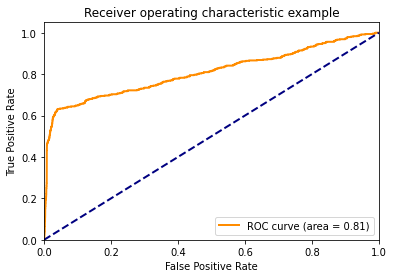

In [0]:
# print ROC curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
fpr = dict()
tpr = dict()
roc_auc = dict()
preds = []
truth = []
model.eval()

with torch.no_grad():
    for batchID, (input, target) in enumerate(dataLoaderTest):
        input = input.to(device)
        target = target.to(device)
        predictions = model(input)
        preds.extend([ a[1].detach().cpu().numpy().item() for a in predictions])
        truth.extend([t.cpu().numpy() for t in target])

print(f'\t AUC:: {roc_auc_score(truth, preds)}')        

for i in range(2,3):
    fpr[i], tpr[i], _ = roc_curve(truth, preds)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(truth, preds)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_curve_12-96.png')
plt.show()